In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [ ]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./drive/My Drive//oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
drive/My Drive/oregon_wildlife/raccoon
drive/My Drive/oregon_wildlife/virginia_opossum
drive/My Drive/oregon_wildlife/cougar
drive/My Drive/oregon_wildlife/black_bear
drive/My Drive/oregon_wildlife/red_fox
drive/My Drive/oregon_wildlife/sea_lions
drive/My Drive/oregon_wildlife/nutria
drive/My Drive/oregon_wildlife/raven
drive/My Drive/oregon_wildlife/deer
drive/My Drive/oregon_wildlife/bald_eagle

total img num: 7168


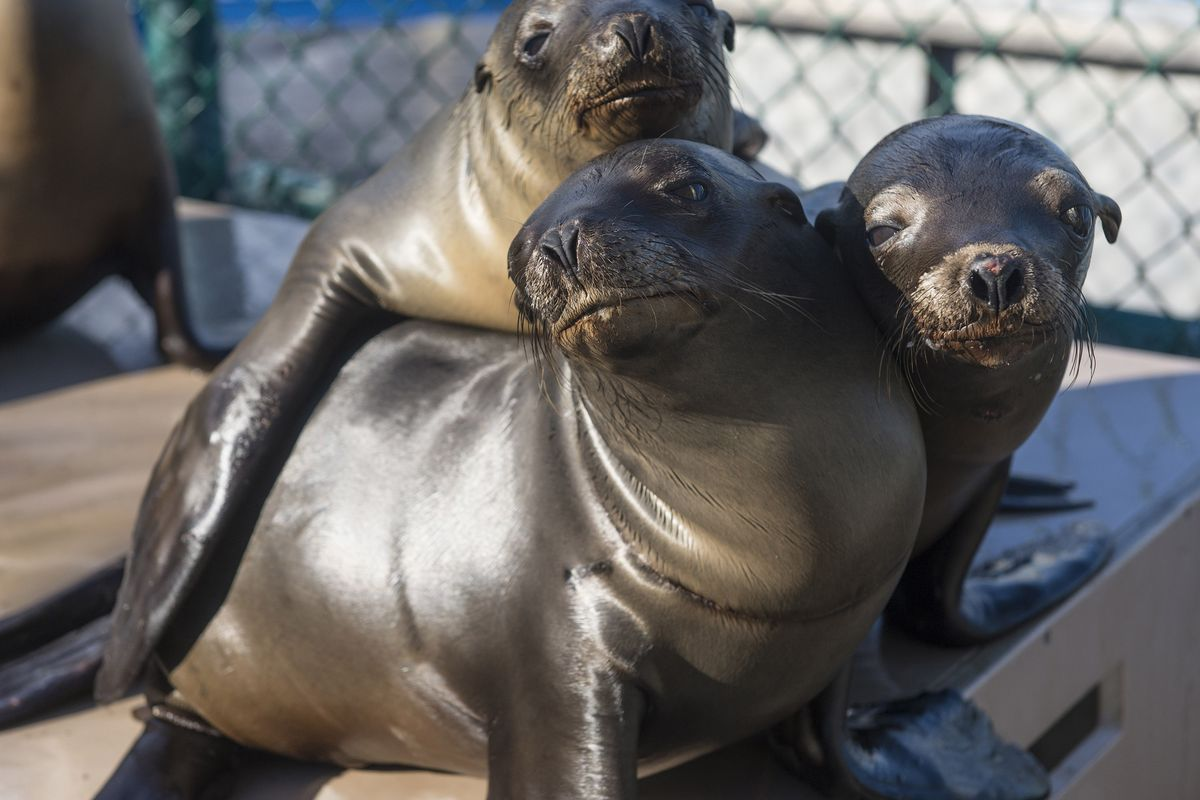

sea_lions


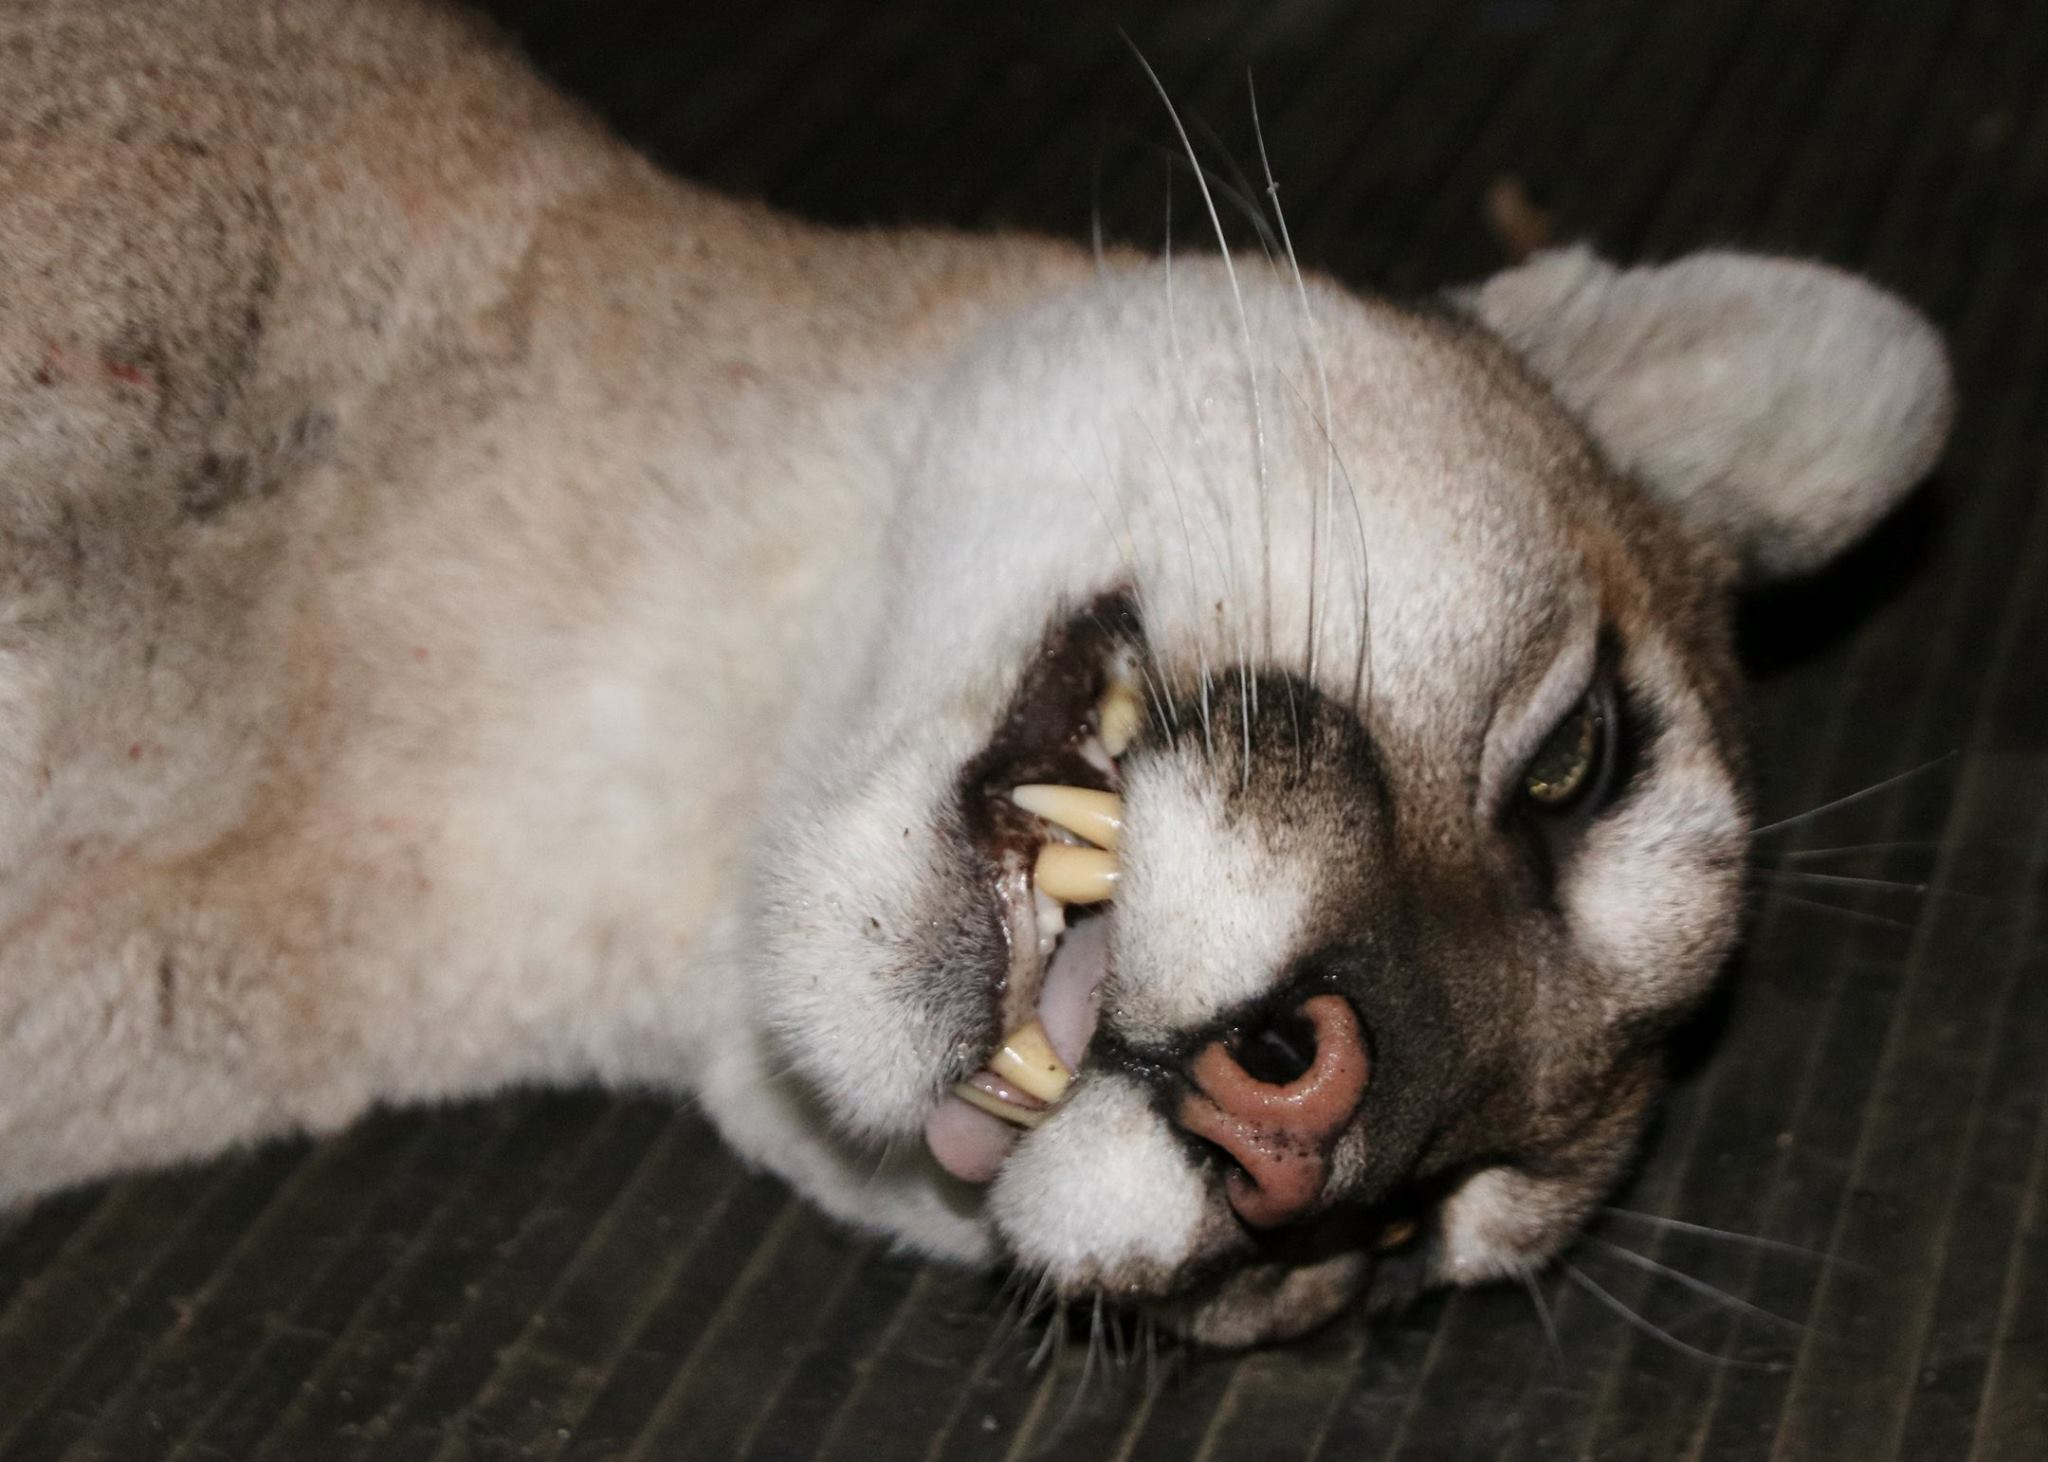

cougar


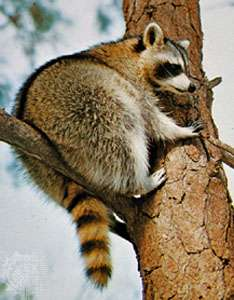

raccoon


In [ ]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [ ]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [ ]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [ ]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [3, 8, 2, 8, 9, 2, 9, 5, 9, 5]


In [ ]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [ ]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [ ]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [ ]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------

        # Reading the file
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [ ]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [ ]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[4.7739120e+02 1.4669217e-02]
 [4.7740588e+02 3.5721183e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


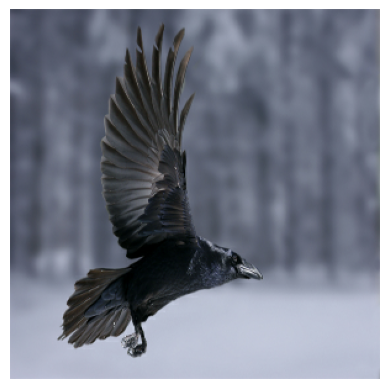

raven


In [ ]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
wild_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 300, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 150, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 10)                  │     174,078,986 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,793,674 (720.19 MB)

 Trainable params: 174,078,986 (664.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# save the initialization of weights
wild_model.save_weights('wild_model.weights.h5')

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [ ]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_state()
        train_accuracy.reset_state()
        test_loss.reset_state()
        test_accuracy.reset_state()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter

            time.sleep(0.05)

            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter

            time.sleep(0.05)

            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [ ]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  713.055130795
training:


100%|██████████| 5734/5734 [22:34<00:00,  4.23it/s]

testing:



100%|██████████| 1434/1434 [05:19<00:00,  4.48it/s]

Epoch 1, Loss: 4.8078, Accuracy: 11.0045, test Loss: 2.2920, test Accuracy: 11.6457
training:



100%|██████████| 5734/5734 [15:28<00:00,  6.18it/s]

testing:



100%|██████████| 1434/1434 [02:37<00:00,  9.12it/s]

Epoch 2, Loss: 2.9138, Accuracy: 10.2895, test Loss: 2.3066, test Accuracy: 9.6932
training:



100%|██████████| 5734/5734 [15:28<00:00,  6.18it/s]

testing:



100%|██████████| 1434/1434 [02:37<00:00,  9.08it/s]

Epoch 3, Loss: 2.3802, Accuracy: 9.9930, test Loss: 2.3470, test Accuracy: 10.3905
Execution time: 3845.4654321750004


In [ ]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

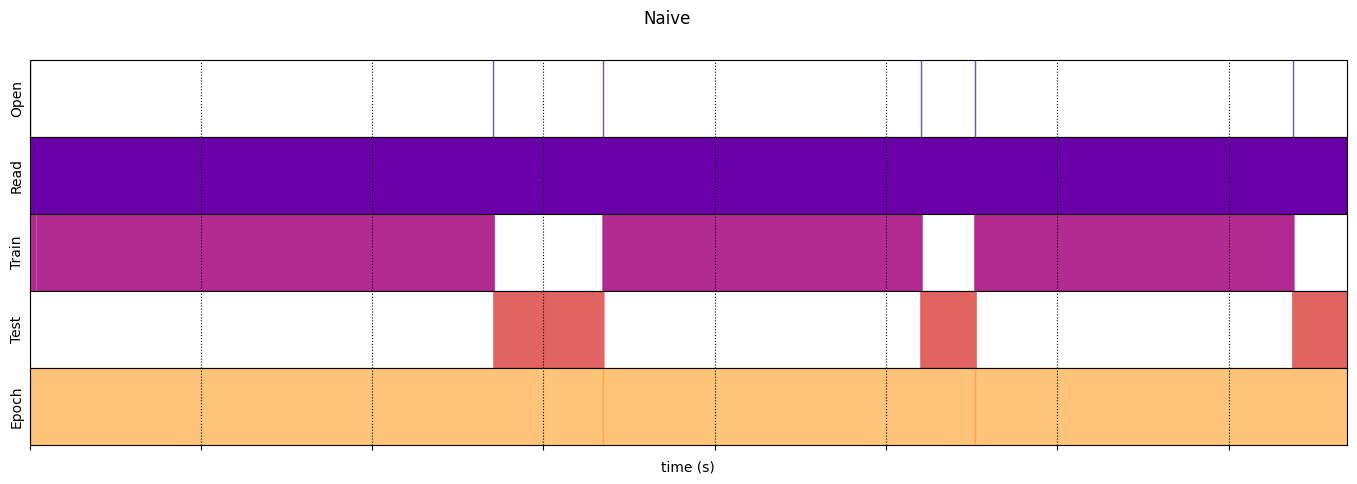

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

Instructions for updating:
Use fn_output_signature instead


tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 7.1532709e+02  2.4202171e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[  0   1  -1]
 [  0   1 812]], shape=(2, 3), dtype=int32)
(300, 300, 3)


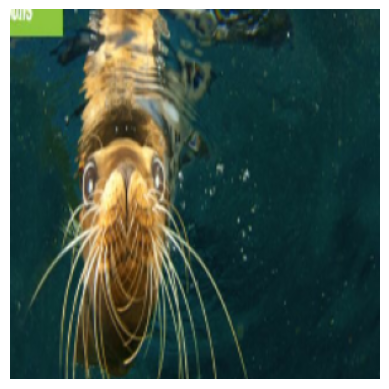

sea_lions


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Randomly crop and resize function for data augmentation, processing a single image
def random_crop_and_resize(image):
    cropped_image = tf.image.random_crop(image, size=[IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, 3])
    resized_image = tf.image.resize(cropped_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return resized_image

# Randomly flip the image horizontally for data augmentation, processing a single image
def random_flip_left_right(image):
    image = tf.image.random_flip_left_right(image)
    return image

# Data preprocessing function to augment only the img
def preprocess_data(img):
    img = random_crop_and_resize(img)
    img = random_flip_left_right(img)
    return img

# Use tf.map_fn to apply augmentation to each image in the batch
def augment_batch(steps, timings, counters, imgs, labels):
    imgs = tf.map_fn(
        preprocess_data,
        imgs,
        dtype=tf.float32  # Only process imgs, return type is tf.float32
    )
    return steps, timings, counters, imgs, labels  # Keep labels unchanged

# Create the augmented training dataset
dataset_train_augmentation = dataset_train \
    .map(augment_batch) \
    .shuffle(buffer_size=1000) \
    .repeat(2)

# Create the augmented test dataset (no data augmentation is usually applied to test datasets)
dataset_test_augmentation = dataset_test

# Display some augmented images and print their shapes
for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.weights.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  772.217025993
training:


11468it [36:15,  5.27it/s]

testing:



100%|██████████| 1434/1434 [05:19<00:00,  4.49it/s]

Epoch 1, Loss: 3.5617, Accuracy: 10.7168, test Loss: 2.3070, test Accuracy: 9.2050
training:



11468it [31:15,  6.11it/s]

testing:



100%|██████████| 1434/1434 [02:38<00:00,  9.07it/s]

Epoch 2, Loss: 2.3620, Accuracy: 10.0628, test Loss: 2.3024, test Accuracy: 11.1576
training:



11468it [31:21,  6.09it/s]

testing:



100%|██████████| 1434/1434 [02:40<00:00,  8.95it/s]

Epoch 3, Loss: 2.3686, Accuracy: 9.9669, test Loss: 2.3049, test Accuracy: 9.9721
Execution time: 6571.351014437


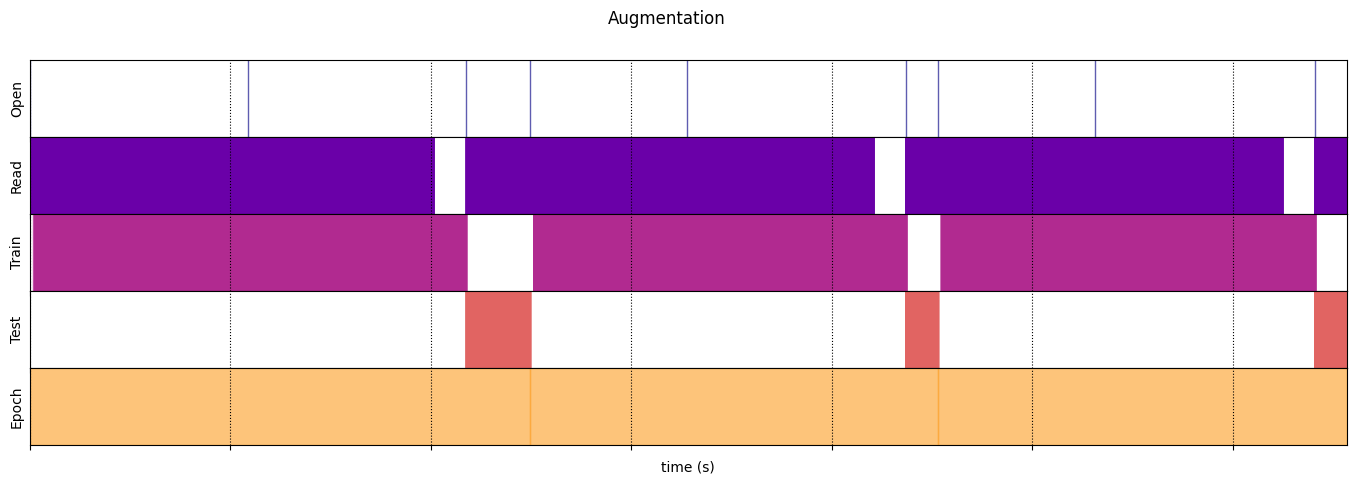

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 7.6691934e+03  6.6446462e-03]], shape=(2, 2), dtype=float32) tf.Tensor(
[[  0   8  -1]
 [  0   8 583]], shape=(2, 3), dtype=int32)


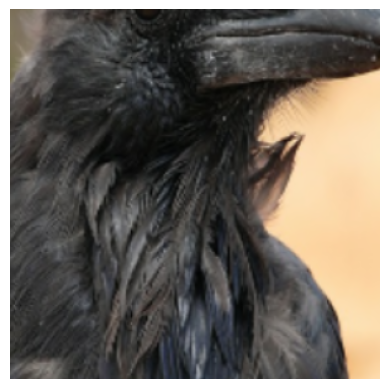

raven


In [ ]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

# Optimized training dataset with caching, prefetching, and parallel processing
dataset_train_optimized = dataset_train_augmentation \
    .cache() \
    .prefetch(tf.data.experimental.AUTOTUNE) \
    .map(augment_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Optimized test dataset with caching and prefetching
dataset_test_optimized = dataset_test_augmentation \
    .cache() \
    .prefetch(tf.data.experimental.AUTOTUNE)

# Example usage: Display some images from the optimized training dataset
for steps, timings, counters, img, label in dataset_train_optimized.take(1):
    print(steps[0], timings[0], counters[0])
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.weights.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  7686.895679364
training:


11468it [31:14,  6.12it/s]

testing:



100%|██████████| 1434/1434 [02:40<00:00,  8.95it/s]

Epoch 1, Loss: 8.2156, Accuracy: 10.1413, test Loss: 2.3026, test Accuracy: 11.2273
training:



11468it [31:18,  6.10it/s]

testing:



100%|██████████| 1434/1434 [02:40<00:00,  8.93it/s]

Epoch 2, Loss: 2.3284, Accuracy: 10.0541, test Loss: 2.3018, test Accuracy: 11.1576
training:



11468it [31:14,  6.12it/s]

testing:



100%|██████████| 1434/1434 [02:39<00:00,  9.02it/s]

Epoch 3, Loss: 2.3230, Accuracy: 10.1064, test Loss: 2.3030, test Accuracy: 11.1576
Execution time: 6107.585883909999


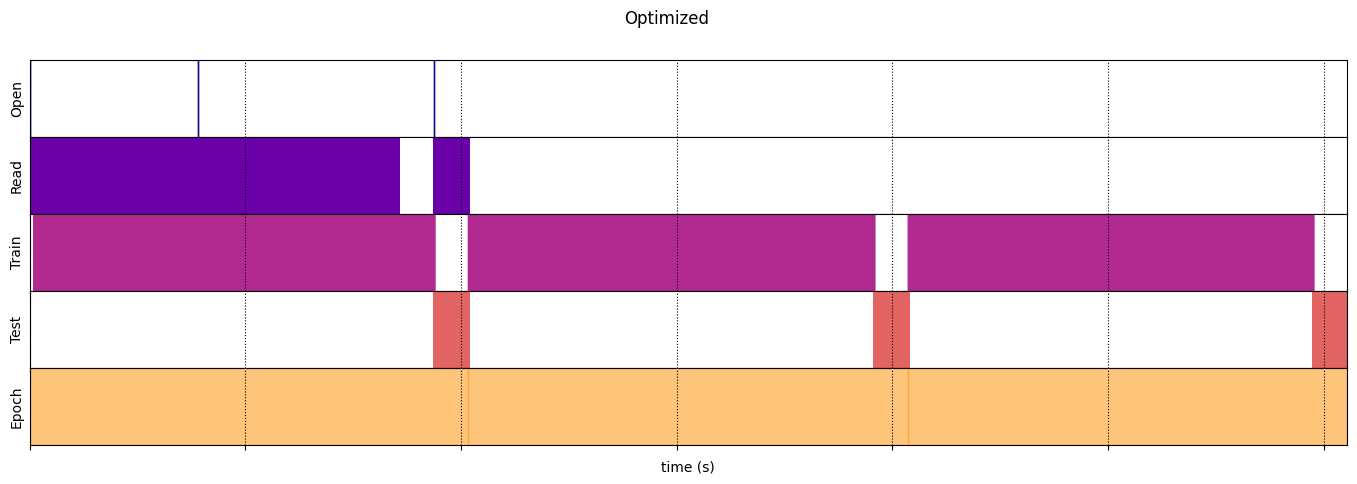

In [ ]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)

# **Report:**
After performing input transformation and data pipeline optimization, the results show that the model’s training and testing accuracy did not significantly improve, and the time consumption remained relatively unchanged. Here is an analysis of the results and related hypotheses:

### Accuracy Analysis

1. **Effect of Input Transformation**: With input transformations such as random cropping, resizing, and flipping, the data became more diverse in each iteration, theoretically improving the model’s generalization ability. However, since training accuracy showed little improvement, this may indicate that the initial model is not yet fully adapted to these transformed data features.
   
2. **Possible Reasons**: I believe that the model architecture itself may lack sufficient depth or adaptability to take full advantage of optimized data, meaning that structural changes to the model could be key to improving the results. Furthermore, as the transformed data introduces more complex features, the model might need additional training epochs to effectively learn these patterns. Therefore, increasing the training epochs or using a more finely-tuned learning rate schedule could help enhance the final results.

### Time Consumption Analysis

1. **Data Pipeline Optimization**: After optimization, the data loading time remained within the expected range and did not significantly impact overall training time. This may be because the device efficiently handles parallel data loading and processing, and no significant bottlenecks emerged in the optimization steps.

2. **Potential Bottlenecks**: In actual execution, batch processing and random data augmentation may be the main time-consuming steps. However, these operations appear to be relatively efficient on this device, with limited room for further optimization.

### Summary and Hypothesis

Overall, input transformation and data pipeline optimization did not yield significant improvements in accuracy or time consumption with the current device and data scale. Hypothetically, increasing the number of training epochs or further fine-tuning model parameters could yield better performance. Additionally, on higher-performance devices, the benefits of data pipeline optimization could be more pronounced, as these devices would more effectively balance the time spent on data loading and model training.